In [3]:
# Initial Imports
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV 
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [4]:
# reading in the data for top 5 largest economies
df = pd.read_csv('WEOApr2021all.csv')
df = df[
    (df["Units"] == "U.S. dollars") | (df["Units"] == "Percent change") | (df["Units"] == "Percent of GDP") | (df["Units"] == "Persons") | (df["Units"] == "Percent of total labor force")]
df.drop(columns=['WEO Country Code','ISO','WEO Subject Code','Subject Notes','Units','Country/Series-specific Notes','Estimates Start After','Scale'], inplace=True)
df = df.T
df.columns = [df.loc["Country"], df.loc['Subject Descriptor']]
df.drop(['Country','Subject Descriptor'],axis=0,inplace=True)
US_df = df['United States']
china_df =df['China']
japan_df = df['Japan']
india_df = df['India']
germany_df = df['Germany']

# clean numeric data
US_df.dropna(axis=1, inplace=True)
US_df = US_df.replace(',','', regex=True)
US_df = US_df.astype("float")

china_df.dropna(axis=1, inplace=True)
china_df = china_df.replace(',','', regex=True)
china_df = china_df.astype("float")

japan_df.dropna(axis=1, inplace=True)
japan_df = japan_df.replace(',','', regex=True)
japan_df = japan_df.astype("float")

india_df.dropna(axis=1, inplace=True)
india_df = india_df.replace(',','', regex=True)
india_df = india_df.astype("float")

germany_df.dropna(axis=1, inplace=True)
germany_df = germany_df.replace(',','', regex=True)
germany_df = germany_df.astype("float")

In [247]:
#US dataframe cleaned all columns
US_df.head()


Subject Descriptor,"Gross domestic product, constant prices","Gross domestic product, current prices","Gross domestic product per capita, current prices",Total investment,Gross national savings,"Inflation, average consumer prices","Inflation, end of period consumer prices",Volume of imports of goods and services,Volume of Imports of goods,Volume of exports of goods and services,Volume of exports of goods,Unemployment rate,Population,Current account balance,Current account balance
1980,-0.257,2857.33,12552.94,23.310,22.053,13.502,11.887,-6.660,-7.449,10.777,12.292,7.175,227.622,2.316,0.081
1981,2.538,3207.03,13948.70,24.277,23.195,10.378,8.569,2.610,2.041,1.219,-0.655,7.617,229.916,5.031,0.157
1982,-1.802,3343.80,14404.99,22.071,21.706,6.158,4.017,-1.275,-2.524,-7.661,-8.479,9.708,232.128,-5.533,-0.165
1983,4.584,3634.03,15513.68,22.253,19.721,3.160,3.930,12.620,13.593,-2.589,-3.274,9.600,234.247,-38.695,-1.065
1984,7.237,4037.65,17086.44,25.096,21.834,4.368,3.896,24.338,24.183,8.157,7.107,7.508,236.307,-94.342,-2.337


In [6]:
# Created X and y for each country 
US_X = US_df.drop(columns=["Gross domestic product, current prices"])
US_y = US_df['Gross domestic product, current prices']

china_X = china_df.drop(columns=["Gross domestic product, current prices"])
china_y = china_df['Gross domestic product, current prices']

japan_X = japan_df.drop(columns=["Gross domestic product, current prices"])
japan_y = japan_df['Gross domestic product, current prices']

india_X = india_df.drop(columns=["Gross domestic product, current prices"])
india_y = india_df['Gross domestic product, current prices']

germany_X = germany_df.drop(columns=["Gross domestic product, current prices"])
germany_y = germany_df['Gross domestic product, current prices']



In [266]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [267]:
window_size = 10

feature_column = 2
target_column = 2
X, y = window_data(US_df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]} ")

X sample values:
[[12552.94 13948.7  14404.99 15513.68 17086.44 18199.32 19034.77 20000.97
  21376.   22814.08]
 [13948.7  14404.99 15513.68 17086.44 18199.32 19034.77 20000.97 21376.
  22814.08 23847.98]
 [14404.99 15513.68 17086.44 18199.32 19034.77 20000.97 21376.   22814.08
  23847.98 24302.78]
 [15513.68 17086.44 18199.32 19034.77 20000.97 21376.   22814.08 23847.98
  24302.78 25392.93]
 [17086.44 18199.32 19034.77 20000.97 21376.   22814.08 23847.98 24302.78
  25392.93 26364.19]] 

y sample values:
[[23847.98]
 [24302.78]
 [25392.93]
 [26364.19]
 [27674.02]] 


In [364]:
# train-test-splits for each country

#US_X_train = X[:int(X.shape[0]*0.7)]
#US_X_test = X[int(X.shape[0]*0.7):]
#US_y_train = y[:int(X.shape[0]*0.7)]
#US_y_test = y[int(X.shape[0]*0.7):]



split = int(0.8 * len(X))
US_X_train = X[: split]
US_X_test = X[split - 20:]
US_y_train = y[: split]
US_y_test = y[split - 20:]

#china_X_train, china_X_test, china_y_train, china_y_test = train_test_split(china_X,china_y)

#japan_X_train, japan_X_test, japan_y_train, japan_y_test = train_test_split(japan_X,japan_y)

#india_X_train, india_X_test, india_y_train, india_y_test = train_test_split(india_X,india_y)

#germany_X_train, germany_X_test, germany_y_train, germany_y_test = train_test_split(germany_X,germany_y)



In [366]:
US_X_train

array([[12552.94, 13948.7 , 14404.99, 15513.68, 17086.44, 18199.32,
        19034.77, 20000.97, 21376.  , 22814.08],
       [13948.7 , 14404.99, 15513.68, 17086.44, 18199.32, 19034.77,
        20000.97, 21376.  , 22814.08, 23847.98],
       [14404.99, 15513.68, 17086.44, 18199.32, 19034.77, 20000.97,
        21376.  , 22814.08, 23847.98, 24302.78],
       [15513.68, 17086.44, 18199.32, 19034.77, 20000.97, 21376.  ,
        22814.08, 23847.98, 24302.78, 25392.93],
       [17086.44, 18199.32, 19034.77, 20000.97, 21376.  , 22814.08,
        23847.98, 24302.78, 25392.93, 26364.19],
       [18199.32, 19034.77, 20000.97, 21376.  , 22814.08, 23847.98,
        24302.78, 25392.93, 26364.19, 27674.02],
       [19034.77, 20000.97, 21376.  , 22814.08, 23847.98, 24302.78,
        25392.93, 26364.19, 27674.02, 28671.48],
       [20000.97, 21376.  , 22814.08, 23847.98, 24302.78, 25392.93,
        26364.19, 27674.02, 28671.48, 29946.97],
       [21376.  , 22814.08, 23847.98, 24302.78, 25392.93, 26364.

In [367]:
US_X_test

array([[22814.08, 23847.98, 24302.78, 25392.93, 26364.19, 27674.02,
        28671.48, 29946.97, 31440.09, 32833.67],
       [23847.98, 24302.78, 25392.93, 26364.19, 27674.02, 28671.48,
        29946.97, 31440.09, 32833.67, 34494.54],
       [24302.78, 25392.93, 26364.19, 27674.02, 28671.48, 29946.97,
        31440.09, 32833.67, 34494.54, 36317.74],
       [25392.93, 26364.19, 27674.02, 28671.48, 29946.97, 31440.09,
        32833.67, 34494.54, 36317.74, 37101.1 ],
       [26364.19, 27674.02, 28671.48, 29946.97, 31440.09, 32833.67,
        34494.54, 36317.74, 37101.1 , 37971.28],
       [27674.02, 28671.48, 29946.97, 31440.09, 32833.67, 34494.54,
        36317.74, 37101.1 , 37971.28, 39411.55],
       [28671.48, 29946.97, 31440.09, 32833.67, 34494.54, 36317.74,
        37101.1 , 37971.28, 39411.55, 41629.86],
       [29946.97, 31440.09, 32833.67, 34494.54, 36317.74, 37101.1 ,
        37971.28, 39411.55, 41629.86, 44025.56],
       [31440.09, 32833.67, 34494.54, 36317.74, 37101.1 , 37971.

In [368]:
US_y_train

array([[23847.98],
       [24302.78],
       [25392.93],
       [26364.19],
       [27674.02],
       [28671.48],
       [29946.97],
       [31440.09],
       [32833.67],
       [34494.54],
       [36317.74],
       [37101.1 ],
       [37971.28],
       [39411.55],
       [41629.86],
       [44025.56],
       [46213.51],
       [47869.24],
       [48283.41],
       [47007.67],
       [48403.3 ],
       [49829.06],
       [51563.13],
       [53071.82],
       [55024.66],
       [56848.51],
       [58017.23],
       [60105.85],
       [63055.98]])

In [369]:
US_y_test

array([[34494.54],
       [36317.74],
       [37101.1 ],
       [37971.28],
       [39411.55],
       [41629.86],
       [44025.56],
       [46213.51],
       [47869.24],
       [48283.41],
       [47007.67],
       [48403.3 ],
       [49829.06],
       [51563.13],
       [53071.82],
       [55024.66],
       [56848.51],
       [58017.23],
       [60105.85],
       [63055.98],
       [65253.52],
       [63415.99],
       [68308.97],
       [71895.79],
       [74130.27],
       [76362.22],
       [78660.27],
       [80958.76]])

In [381]:
# Created models for each country
#Parameters = {"n_estimators": [1, 2, 5, 10, 15], 
#          "max_depth": [None, 2, 5, 8, 10]
#          }
#US_model = RandomForestRegressor()
#Grid = GridSearchCV(US_model, Parameters)
#Grid.fit(US_X_train, US_y_train)
#Grid.best_params_
#US_model = RandomForestRegressor(max_depth = 5, n_estimators = 3)
#US_model.fit(US_X_train, US_y_train)






#US_model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=0)
#US_model.fit(US_X_train, US_y_train)

#china_model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=0)
#china_model.fit(china_X_train, china_y_train)

#japan_model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=0)
#japan_model.fit(japan_X_train, japan_y_train)

#india_model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=0)
#india_model.fit(india_X_train, india_y_train)

#germany_model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=0)
#germany_model.fit(germany_X_train, germany_y_train)

NameError: name 'random_state' is not defined

In [371]:
US_GDP_Predict = US_model.predict(US_X_test)
US_GDP_Predict

array([31999.89666667, 37002.39666667, 37871.25      , 38451.37      ,
       38931.46      , 41688.99      , 44025.56      , 46213.51      ,
       48055.05777778, 48055.05777778, 47633.44444444, 48664.15833333,
       49829.06      , 50985.10666667, 52641.84666667, 53219.87      ,
       57627.65666667, 58017.23      , 60105.85      , 60393.02      ,
       60393.02      , 60393.02      , 60393.02      , 60393.02      ,
       60393.02      , 60393.02      , 60393.02      , 60393.02      ])

In [372]:
from sklearn.metrics import mean_squared_error, r2_score

In [373]:
r2 = r2_score(US_y_test, US_GDP_Predict)
r2

0.7128413687189376

In [374]:
mse = mean_squared_error(US_y_test, US_GDP_Predict)
mse

51709959.105382524

In [375]:
rmse = np.sqrt(mse)
rmse

7190.963711866618

In [376]:
#Biggest Contributor to model prediction
importances = US_model.feature_importances_
sorted(zip(US_model.feature_importances_, US_X.columns), reverse=True)

[(0.26205645308080483, 'Inflation, average consumer prices'),
 (0.2605154201745979, 'Total investment'),
 (0.25331554993454436, 'Inflation, end of period consumer prices'),
 (0.068791277271396, 'Gross domestic product, constant prices'),
 (0.059043329035726184, 'Volume of exports of goods and services'),
 (0.0395463666205021, 'Gross domestic product per capita, current prices'),
 (0.03079699908461442, 'Gross national savings'),
 (0.01675628619894412, 'Volume of Imports of goods'),
 (0.005619590469577971, 'Volume of imports of goods and services'),
 (0.0035587281292922533, 'Volume of exports of goods')]

<AxesSubplot:title={'center':'Features Importances that Factor Into US GDP'}, ylabel='1'>

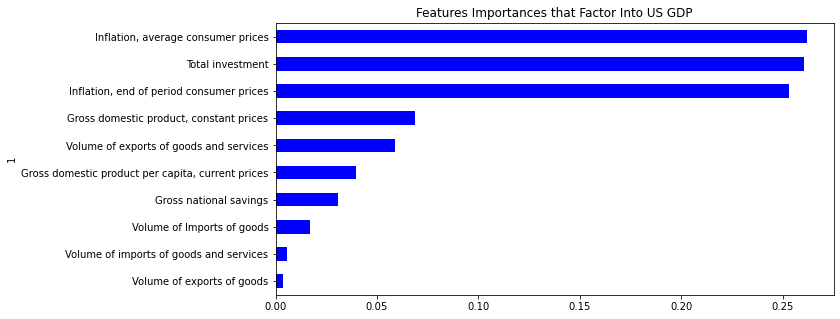

In [377]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(US_model.feature_importances_, US_X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(figsize=(10,5), kind='barh', color='Blue', title= 'Features Importances that Factor Into US GDP', legend=False)

In [378]:
#Accuracy using training data
US_model.score(US_X_train, US_y_train)  

0.9940854807122056

In [379]:
#Accuracy using test data
US_model.score(US_X_test, US_y_test)  

0.7128413687189376

<AxesSubplot:>

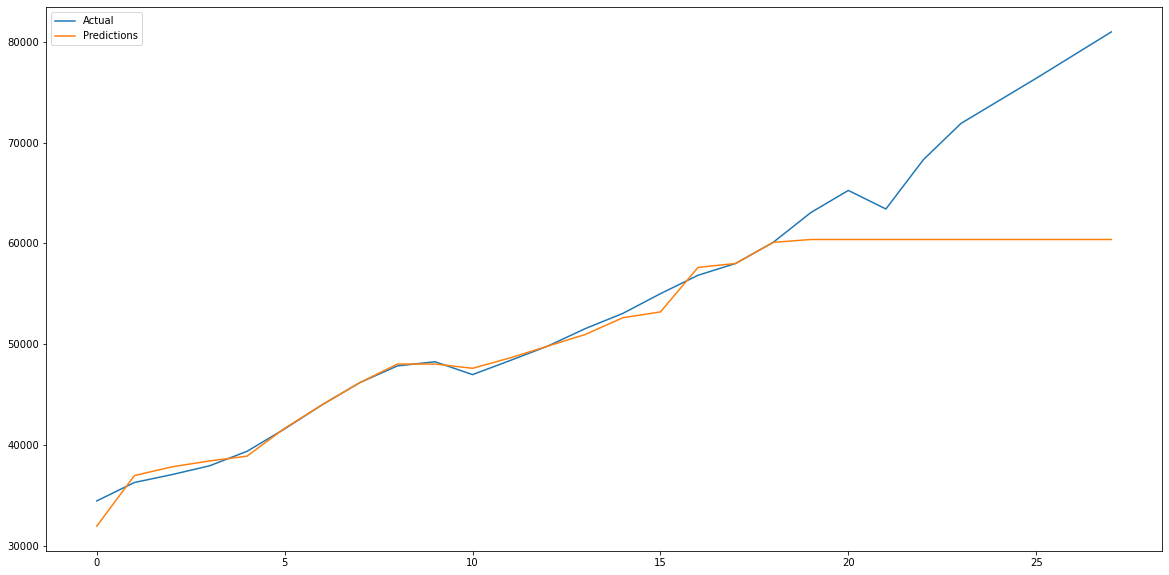

In [380]:
US_pred_results = pd.DataFrame({"Actual": US_y_test.ravel(), "Predictions": US_GDP_Predict.ravel()})
#US_pred_results["Actual"] = US_y_test
#US_pred_results["Predictions"] = US_GDP_Predict
US_pred_results.plot(figsize=(20,10))

In [184]:
US_df.shape

(47, 15)